In [ ]:
# @title Unesi prompt:

# samo da se ne izgubi: "a futuristic city skyline at sunset, cyberpunk style"
prompt = "a photo of an astronaut riding a horse on mars" # @param {type:"string"}

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

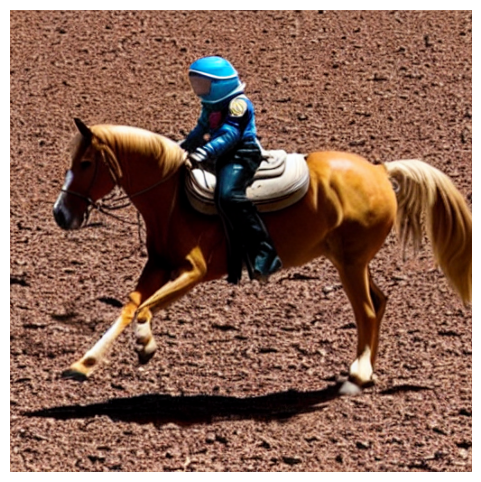

In [ ]:
# ovako je napravljeno kako se ne bi trebalo ulogirati svaki put na huggingface
# također da se ne spremi na disk nego da se odmah slika ispod prikaže

!pip install diffusers transformers accelerate torch matplotlib scikit-image pandas

import torch
import numpy as np
import time
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, LMSDiscreteScheduler, DDIMScheduler
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import pandas as pd

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    #scheduler=EulerDiscreteScheduler()
).to("cuda")

# Generiranje slike
image = pipe(prompt).images[0]  # Ovo vraća jednu sliku

# Prikaz slike
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")  # Sakrij osi
plt.show()

# # Učitaj Stable Diffusion 1.5 model
# model_id = "runwayml/stable-diffusion-v1-5"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=DDIMScheduler(), torch_dtype=torch.float16)
# pipe.to("cuda")  # Pokreće model na GPU-u

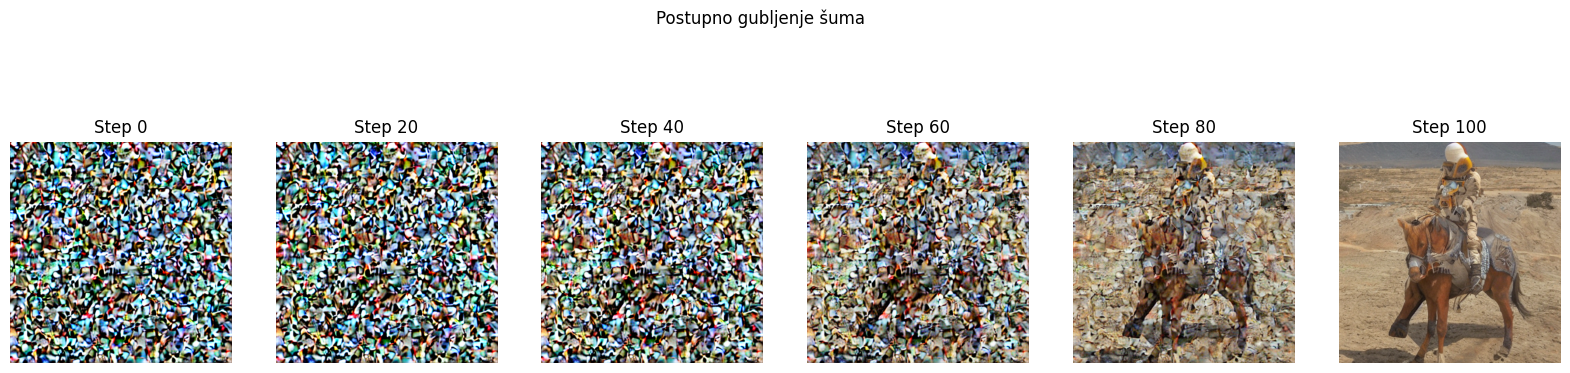

In [ ]:
num_inference_steps = 100
pipe.scheduler.set_timesteps(num_inference_steps)

# Inicijalizacija latentnog prostora
latents = torch.randn(
    (1, pipe.unet.config.in_channels, pipe.unet.config.sample_size, pipe.unet.config.sample_size),
    device="cuda",
    dtype=torch.float16,
)

# Encode text
text_inputs = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")
text_embeddings = pipe.text_encoder(text_inputs.input_ids.to("cuda"))[0]

# Pohrana slika
images = []
save_interval = 20  # Spremaj svakih 20 koraka

for step in range(num_inference_steps):
    timestep = pipe.scheduler.timesteps[step]

    # Generacija predikcije šuma
    with torch.no_grad():
        latents = pipe.scheduler.scale_model_input(latents, timestep)
        noise_pred = pipe.unet(latents, timestep, encoder_hidden_states=text_embeddings).sample

    # Ažuriranje latenta
    latents = pipe.scheduler.step(noise_pred, timestep, latents).prev_sample

    # Dekodiranje slike
    if step % save_interval == 0 or step == num_inference_steps - 1:  # Spremaj svakih 20 koraka + zadnji
        with torch.no_grad():
            image = pipe.decode_latents(latents)  # Poboljšana metoda dekodiranja (može se koristit i VAE)
            image_np = np.clip(image[0] * 255, 0, 255).astype("uint8")
            images.append(image_np)

# Vizualizacija generiranih slika
num_visualize_steps = len(images)
fig, axes = plt.subplots(1, num_visualize_steps, figsize=(20, 5))
for i in range(num_visualize_steps):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis("off")
    ax.set_title(f"Step {i * save_interval}")
plt.suptitle("Postupno gubljenje šuma")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

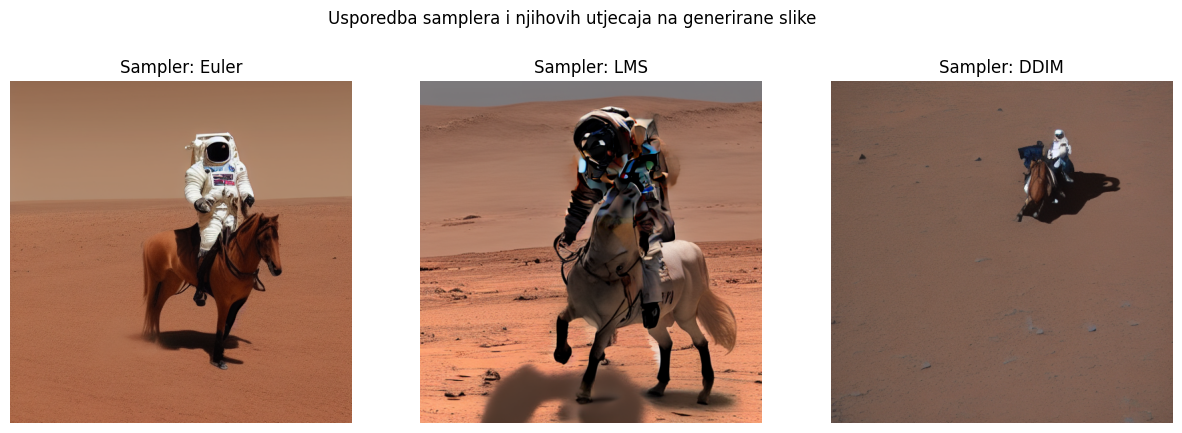

       Time (s)  Inference Steps SSIM vs First
Euler      1.80               10           N/A
LMS        1.89               10        0.4277
DDIM       1.77               10        0.5801


In [ ]:
# Eksperimentiranje s različitim metodama pretrage (samplerima)

samplers = {
    "Euler": EulerDiscreteScheduler.from_config(pipe.scheduler.config),
    "LMS": LMSDiscreteScheduler.from_config(pipe.scheduler.config),
    "DDIM": DDIMScheduler.from_config(pipe.scheduler.config),
}

results = {}
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
num_inference_steps = 10
first_image = None

# Generate images with each sampler and collect statistics
for i, (name, scheduler) in enumerate(samplers.items()):
    pipe.scheduler = scheduler  # Set the new sampler

    # Za točan timing
    torch.cuda.synchronize()
    start_time = time.time()
    image = pipe(prompt, num_inference_steps=num_inference_steps).images[0]
    torch.cuda.synchronize()
    end_time = time.time()

    image_np = np.array(image.convert("L")) / 255.0  # Grayscale + normalizirano

    # Izračunavanje SSIM-a (u odnosu na prvu sliku)
    ssim_value = ssim(first_image, image_np, data_range=1.0) if first_image is not None else None
    if first_image is None:
        first_image = image_np

    results[name] = {
        "Time (s)": round(end_time - start_time, 2),
        "Inference Steps": num_inference_steps,
        "SSIM vs First": round(ssim_value, 4) if ssim_value is not None else "N/A"
    }

    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Sampler: {name}")

# Prikaz svih slika
plt.suptitle("Usporedba samplera i njihovih utjecaja na generirane slike")
plt.show()

# Statistika
df = pd.DataFrame.from_dict(results, orient="index")
print(df)

In [ ]:
!nvidia-smi

Sun Feb  2 20:55:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             31W /   70W |   15070MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----